In [163]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lxml
from lxml import html
import requests

In [17]:
class Stock:
    def __init__(self, symbol):
        self.symbol = symbol
        
    def fetch_all(self):
        self.fetch_balance_sheet()
        self.fetch_income_statement()
        self.fetch_cash_flow()
        self.fetch_statistics()
        self.fetch_prices()
        self.fetch_dividends()
        
    def fetch_executive(self):
        self.fetch_balance_sheet()
        self.fetch_income_statement()
        self.fetch_statistics()
        
    def fetch_balance_sheet(self):
        url = 'https://finance.yahoo.com/quote/' + self.symbol + '/balance-sheet?p=' + self.symbol

        page = requests.get(url)
        # Parse the page with LXML, so that we can start doing some XPATH queries
        # to extract the data that we want
        tree = html.fromstring(page.content)

        # Using XPATH, fetch all table elements on the page
        table = tree.xpath('//table') 

        assert len(table) == 1 

        # Now that we've got the table element, convert it back to a string,
        # so that it can be parsed by Pandas
        tstring = lxml.etree.tostring(table[0], method='html')

        # Read the HTML table into a Pandas DataFrame - read_html
        # is designed to read HTML tables into a list of dataframe objects,
        # one dataframe for each table.
        df = pd.read_html(tstring)[0]

        df = df.set_index(0) # Set the index to the first column: 'Period Ending'.
        df = df.dropna() # Get rid of rows containing 'NaN'
        df = df.transpose() # Transpose the DataFrame, so that our header contains the account names
        df[df.columns[0]] = pd.to_datetime(df[df.columns[0]])
        df = df.set_axis(df.columns, axis='columns', inplace=False)

        df = df.replace('-', '0') # Remove the '-' values that can't be converted to numeric.
        df = df.drop(columns=["Current Assets", "Current Liabilities", "Stockholders' Equity"])
        numeric_columns = list(df.columns)[1::] # Take all columns, except the first (which is the 'Period Date' column)
        df[numeric_columns] = df[numeric_columns].astype(np.float64) # Convert all columns to float64
        self.balance_sheet = df
        
    def fetch_income_statement(self):
        url = f"https://finance.yahoo.com/quote/{self.symbol}/financials?p={self.symbol}"
        
        page = requests.get(url)
        tree = html.fromstring(page.content)
        table = tree.xpath('//table') 

        assert len(table) == 1 
        tstring = lxml.etree.tostring(table[0], method='html')
        
        df = pd.read_html(tstring)[0]

        df = df.set_index(0) # Set the index to the first column: 'Period Ending'.
        df = df.dropna() # Get rid of rows containing 'NaN'
        df = df.transpose() # Transpose the DataFrame, so that our header contains the account names
        df[df.columns[0]] = pd.to_datetime(df[df.columns[0]])
        df = df.set_axis(df.columns, axis='columns', inplace=False)

        df = df.replace('-', '0') # Remove the '-' values that can't be converted to numeric.
        df = df.drop(columns=["Operating Expenses", "Income from Continuing Operations", "Non-recurring Events", "Net Income"])
        numeric_columns = list(df.columns)[1::] # Take all columns, except the first (which is the 'Period Date' column)
        df[numeric_columns] = df[numeric_columns].astype(np.float64) # Convert all columns to float64
        self.income_statement = df
        
    def fetch_cash_flow(self):
        url = f"https://finance.yahoo.com/quote/{self.symbol}/cash-flow?p={self.symbol}"
        
        page = requests.get(url)
        tree = html.fromstring(page.content)
        table = tree.xpath('//table') 

        assert len(table) == 1 
        
        tstring = lxml.etree.tostring(table[0], method='html')
        
        df = pd.read_html(tstring)[0]

        df = df.set_index(0) # Set the index to the first column: 'Period Ending'.
        df = df.dropna() # Get rid of rows containing 'NaN'
        df = df.transpose() # Transpose the DataFrame, so that our header contains the account names
        df[df.columns[0]] = pd.to_datetime(df[df.columns[0]])
        df = df.set_axis(df.columns, axis='columns', inplace=False)

        df = df.replace('-', '0') # Remove the '-' values that can't be converted to numeric.
        df = df.drop(columns=["Operating Activities, Cash Flows Provided By or Used In", "Investing Activities, Cash Flows Provided By or Used In", "Financing Activities, Cash Flows Provided By or Used In"])
        numeric_columns = list(df.columns)[1::] # Take all columns, except the first (which is the 'Period Date' column)
        df[numeric_columns] = df[numeric_columns].astype(np.float64) # Convert all columns to float64
        self.cash_flow = df
        
    def fetch_statistics(self):
        url = f"https://finance.yahoo.com/quote/{self.symbol}/key-statistics?p={self.symbol}"
        
        page = requests.get(url)
        tree = html.fromstring(page.content)
        table = tree.xpath('//table') 

        df = pd.DataFrame()

        for i in range(0, 9):
            tstring = lxml.etree.tostring(table[i], method='html')

            df_part = pd.read_html(tstring)[0]

            df_part = df_part.set_index(0) # Set the index to the first column: 'Period Ending'.
            df_part = df_part.dropna() # Get rid of rows containing 'NaN'

            df = pd.concat([df, df_part])

        df.index.rename("Index")
        df.columns = ["Value"]    
        self.statistics = df
        
    def fetch_prices(self):
        period = "1mo"
        url = f"https://finance.yahoo.com/quote/{self.symbol}/history?period1=1337292000&period2=1563055200&interval={period}&filter=history&frequency={period}"
        page = requests.get(url)
        tree = html.fromstring(page.content)
        table = tree.xpath('//table') 

        assert len(table) == 1 

        tstring = lxml.etree.tostring(table[0], method='html')

        df = pd.read_html(tstring)[0]
        df = df.set_index("Date") # Set the index to the first column: 'Period Ending'.
        df = df.dropna() # Get rid of rows containing 'NaN'
        df = df.set_axis(df.columns, axis='columns', inplace=False)

        df = df.replace('-', '0') # Remove the '-' values that can't be converted to numeric.
        numeric_columns = list(df.columns)[0::] # Take all columns, except the first (which is the 'Period Date' column)
        df.drop(df.tail(1).index,inplace=True)

        for i in range(1, df["Close*"].count()):
            try:
                if df.iloc[i]["Close*"][-8::] == "Dividend" or df.iloc[i]["Close*"][-5::] == "Split":
                    df = df.drop(df.index[i])
            except: 
                pass

        df[numeric_columns] = df[numeric_columns].astype(np.float64)
        self.prices = df
        
    def fetch_dividends(self):
        url = f"https://finance.yahoo.com/quote/{self.symbol}/history?period1=1&period2=1563055200&interval=div%7Csplit&filter=div&frequency=1mo"
        page = requests.get(url)
        tree = html.fromstring(page.content)
        table = tree.xpath('//table') 

        assert len(table) == 1 

        tstring = lxml.etree.tostring(table[0], method='html')

        try:
            df = pd.read_html(tstring)[0]
            df = df.set_index("Date") # Set the index to the first column: 'Period Ending'.
            df = df.dropna() # Get rid of rows containing 'NaN'
            df = df.set_axis(df.columns, axis='columns', inplace=False)
            df = df.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4", "Unnamed: 5", "Unnamed: 6"])
            df = df.replace('-', '0')
            self.dividends = df
        except:
            pass

In [3]:
class Macro_Economics:
    def __init(self):
        pass
    
    def fetch_indices_prices(self):
        self.df_sp500 = self.fetch_prices("^GSPC")
        self.df_dow = self.fetch_prices("^DJI")
        self.df_nasdaq = self.fetch_prices("^IXIC")
        self.df_dax = self.fetch_prices("^GDAXI")
        self.df_hang_seng = self.fetch_prices("^HSI")
    
    def fetch_prices(self, symbol):
        period = "1mo"
        url = f"https://finance.yahoo.com/quote/{symbol}/history?period1=1&period2=1563055200&interval={period}&filter=history&frequency={period}"
        page = requests.get(url)
        tree = html.fromstring(page.content)
        table = tree.xpath('//table') 

        assert len(table) == 1 

        tstring = lxml.etree.tostring(table[0], method='html')

        df = pd.read_html(tstring)[0]
        df = df.set_index("Date") # Set the index to the first column: 'Period Ending'.
        df = df.dropna() # Get rid of rows containing 'NaN'
        df = df.set_axis(df.columns, axis='columns', inplace=False)

        df = df.replace('-', '0') # Remove the '-' values that can't be converted to numeric.
        #df = df.drop(columns=["Operating Activities, Cash Flows Provided By or Used In", "Investing Activities, Cash Flows Provided By or Used In", "Financing Activities, Cash Flows Provided By or Used In"])
        numeric_columns = list(df.columns)[0::] # Take all columns, except the first (which is the 'Period Date' column)
        df.drop(df.tail(1).index,inplace=True)
        df[numeric_columns] = df[numeric_columns].astype(np.float64) # Convert all columns to float64
        return df

In [176]:
class Analysis:
    def __init__(self, stock):
        self.stock = stock
        self.symbol = self.stock.symbol
        
    def discounted_cash_flow(self):
        # It's not 100% accurate today, needs a bit of adjustment in the future.
        tax_rate = np.mean([self.stock.income_statement["Income Tax Expense"][i]/self.stock.income_statement["Income Before Tax"][i] for i in range(1,4)])
        growth_rate_5years = np.mean([self.stock.income_statement["Net Income Applicable To Common Shares"][i]/self.stock.income_statement["Net Income Applicable To Common Shares"][i+1] for i in range(1,4)]) - 1
        growth_rate_infinite = 0.07 if growth_rate_5years > 0 else growth_rate_5years
        coc = 0.158

        """if self.stock.statistics.iloc[47]["Value"][-1] == "B":
            ebitda = float(self.stock.statistics.iloc[47]["Value"][:-1]) * 10**9
        elif self.stock.statistics.iloc[47]["Value"][-1] == "M":
            ebitda = float(self.stock.statistics.iloc[47]["Value"][:-1]) * 10**6
        else:
            ebitda = float(self.stock.statistics.iloc[47]["Value"][:-1])"""

        #fcf = ((self.stock.income_statement["Income Before Tax"][1] * (1 - tax_rate)) + self.stock.cash_flow["Depreciation"][1] - (self.stock.balance_sheet["Total Assets"][1] - self.stock.balance_sheet["Total Liabilities"][1]) + self.stock.cash_flow["Capital Expenditures"][1]) * 1000
        #Ebita * 1 - Tax_Rate is suprisingly accurate to simplywallst.
        fcf = (self.stock.income_statement["Income Before Tax"][1] * (1 - tax_rate)) * 10 ** 3

        dcf = fcf

        for i in range(1, 5):
            dcf = dcf + (fcf * ((1 + growth_rate_5years)**i))/((1 + coc)**i)

        for i in range(5, 15):
            dcf = dcf + (fcf * ((1 + np.mean([growth_rate_infinite, growth_rate_5years])**i)))/((1 + coc)**i)

        dcf = dcf + (fcf * (1 + growth_rate_infinite))/(coc - growth_rate_infinite)

        if self.stock.statistics.iloc[18]["Value"][-1] == "B":
            n_stocks = float(self.stock.statistics.iloc[18]["Value"][:-1]) * 10**9
        elif self.stock.statistics.iloc[18]["Value"][-1] == "M":
            n_stocks = float(self.stock.statistics.iloc[18]["Value"][:-1]) * 10**6
        else:
            n_stocks = float(self.stock.statistics.iloc[18]["Value"][:-1])

        self.intrinsic_value = dcf / n_stocks
        self.discount_value =  1 - (self.stock.prices["Close*"][0] / self.intrinsic_value)
    
    def calculate_macro_correlations(self):
        correlations = []
        n_rows = self.stock.prices["Close*"].count()
        correlations.append(np.corrcoef(x = Macro.df_sp500["Close*"].iloc[:n_rows], y = self.stock.prices["Close*"])[0][1])
        correlations.append(np.corrcoef(x = Macro.df_dow["Close*"].iloc[:n_rows], y = self.stock.prices["Close*"])[0][1])
        correlations.append(np.corrcoef(x = Macro.df_nasdaq["Close*"].iloc[:n_rows], y = self.stock.prices["Close*"])[0][1])
        correlations.append(np.corrcoef(x = Macro.df_dax["Close*"].iloc[:n_rows], y = self.stock.prices["Close*"])[0][1])
        correlations.append(np.corrcoef(x = Macro.df_hang_seng["Close*"].iloc[:n_rows], y = self.stock.prices["Close*"])[0][1])
        self.indices_correlations = correlations
        self.average_correlation = np.mean(correlations)
        
    def calculate_portfolio_correlation(self):
        if len(self.portfolio) > 0:
            for i in range(0, len(self.portfolio)):
                self.portfolio[i].fetch_prices()
                
            correlations = []
            
            for i in range(0, len(self.portfolio)):
                n_rows = self.stock.prices["Close*"].count() if self.stock.prices["Close*"].count() < self.portfolio[i].prices["Close*"].count() else self.portfolio[i].prices["Close*"].count()
                correlations.append(np.corrcoef(x = self.portfolio[i].prices["Close*"].iloc[:n_rows], y = self.stock.prices["Close*"].iloc[:n_rows])[0][1])
                
            self.portfolio_correlations = correlations
            self.average_portfolio_correlations = np.mean(correlations)                
    
    def input_portfolio(self, symbols):
        portfolio_symbols = []
        self.portfolio_symbols = symbols
        
        for i in range(0, len(symbols)):
            portfolio_symbols.append(Stock(symbols[i]))
            
        if len(portfolio_symbols) >= 0:
            self.portfolio = portfolio_symbols            
            
    def show_correlations(self):
        self.calculate_macro_correlations()
        self.calculate_portfolio_correlation()
        
        fig, axs = plt.subplots(ncols=2)
        sns.barplot(x=["Macro", "Portfolio"], y=[self.average_correlation, self.average_portfolio_correlations], ax=axs[0], palette=["#086788", "#619EB3"], )
        sns.barplot(x=self.portfolio_symbols, y=self.portfolio_correlations, ax=axs[1], palette=["#086788", "#619EB3"], )

In [18]:
Macro = Macro_Economics()
Macro.fetch_indices_prices()

In [76]:
Focus_Stock_Data = Stock("INTC")
Focus_Stock_Data.fetch_all()

In [177]:
Analysis_Now = Analysis(Focus_Stock_Data)
Analysis_Now.calculate_macro_correlations()

In [68]:
Analysis_Now.discounted_cash_flow()
Analysis_Now.intrinsic_value

81.53286952011166

In [178]:
Analysis_Now.input_portfolio(["FB", "GOOG", "F"])

<Figure size 2160x1440 with 0 Axes>

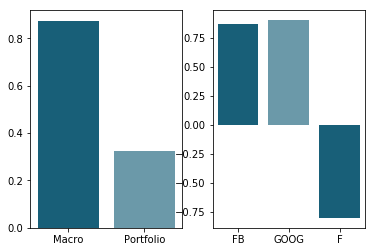

In [179]:
Analysis_Now.show_correlations()

In [ ]:
# Getting Ebitda needs fixing. For Tesla EBITDA is index 38, for F, FB its 47
Focus_Stock_Data.statistics.iloc[38]["Value"][-1]